In [1]:
import os
import pickle
from torchvision import transforms
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

/home/jmorales/miniconda3/envs/stvqa_rl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/data/users/jmorales/svhn/"

# Load splits data
with open(data_dir + "train_data.pkl", "rb") as f:
    train_data = pickle.load(f)
with open(data_dir + "val_data.pkl", "rb") as f:
    val_data = pickle.load(f)
with open(data_dir + "test_data.pkl", "rb") as f:
    test_data = pickle.load(f)

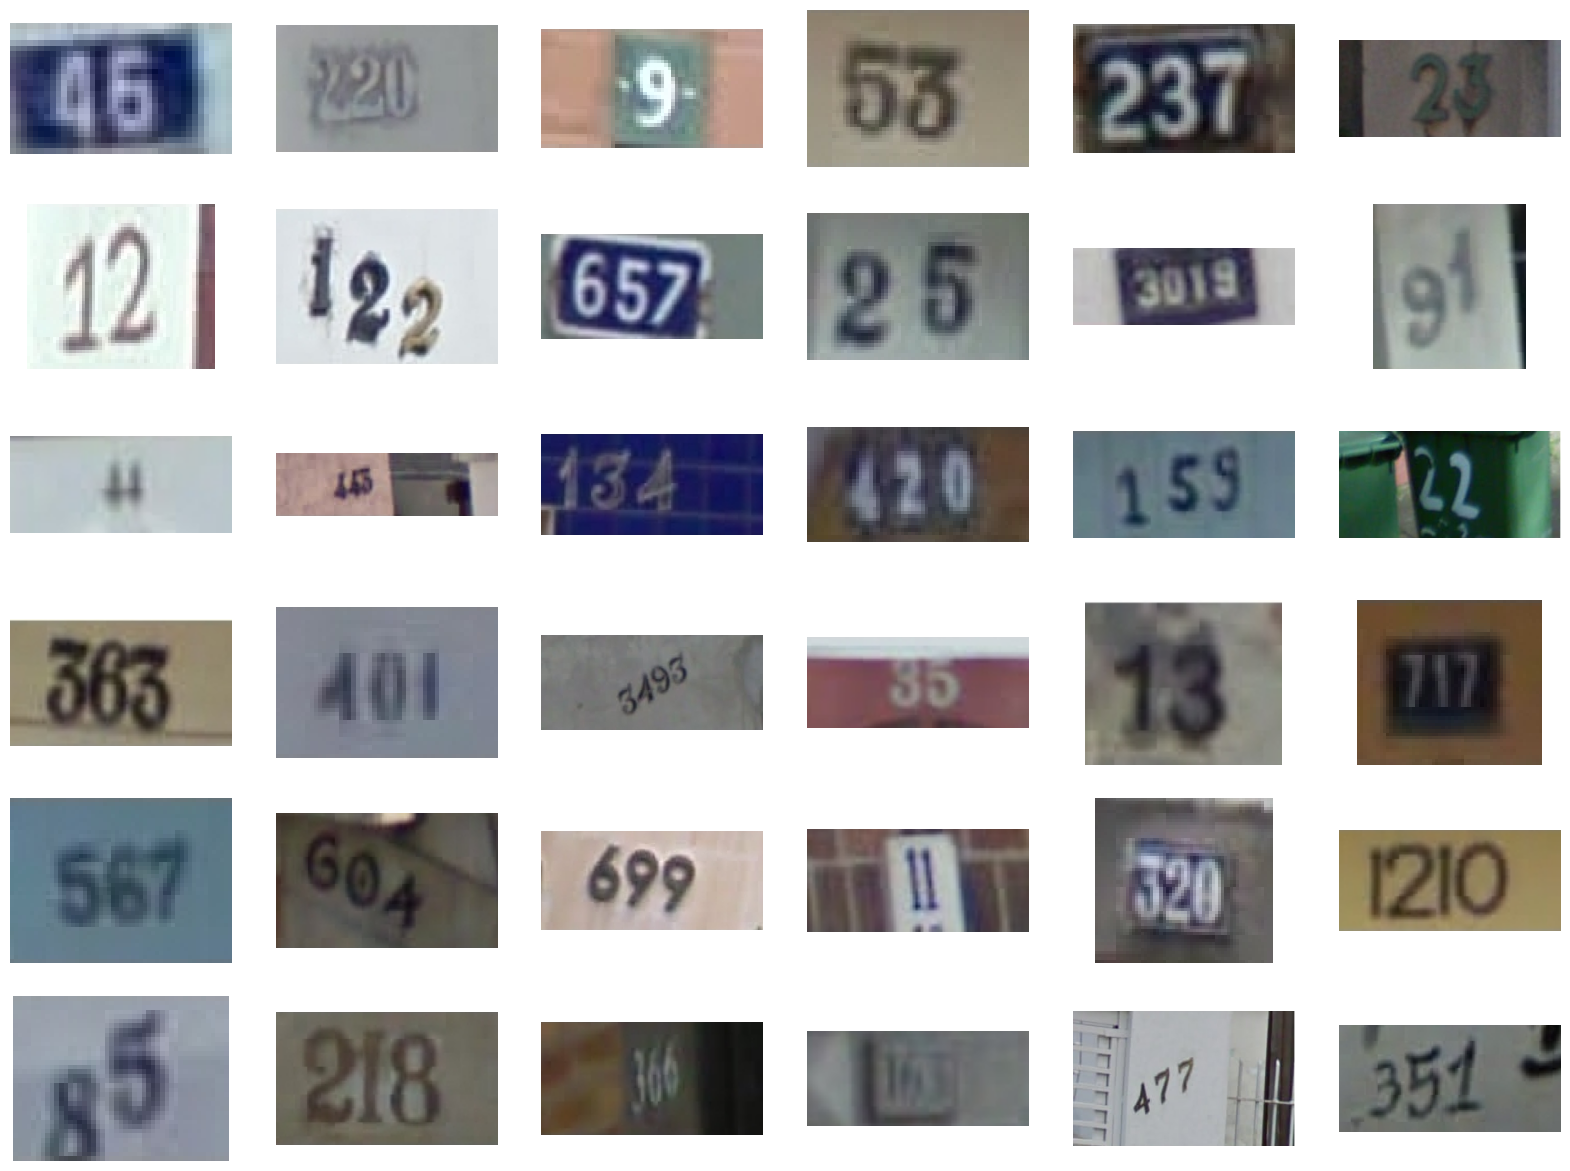

In [33]:
nrows, ncols = 6, 6
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))

for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(0, len(train_data))
        current_sample = train_data[idx]#train_data[45]

        # Read image
        img_path = os.path.join(data_dir, current_sample["dataset_split"], current_sample["filename"])
        img = Image.open(img_path)
        
        ax[i, j].axis(False)
        ax[i, j].imshow(img)

#### Visualize the different steps of the preprocessing method

In [21]:
import random

#142954, 178377, 53593, 175213, 120301, 185366, 3584, 36429
idx = 36429#random.randint(0, len(train_data))
current_sample = train_data[idx]#train_data[45]

# Define transforms
train_trans = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize((64, 64)),
            transforms.RandomCrop((54, 54))])

# Read image
img_path = os.path.join(data_dir, current_sample["dataset_split"], current_sample["filename"])
img = Image.open(img_path)


w, h = img.size
bboxes = current_sample["boxes"]

img_boxes = img.copy()
img_draw = ImageDraw.Draw(img_boxes)
for box in bboxes:
    shape = [(box["left"], box["top"]), (box["left"]+box["width"], box["top"]+box["height"])]
    img_draw.rectangle(shape, outline ="green")

# Get smaller bounding box that contain all digit bounding boxes
x1 = min([i["left"] for i in bboxes])
y1 = min([i["top"] for i in bboxes])
x2 = max([i["left"] + i["width"] for i in bboxes])
y2 = max([i["top"] + i["height"] for i in bboxes])

img_draw.rectangle(((x1, y1), (x2, y2)), outline ="orange")

# Expand this bbox by 30% in both x and y axis
x1 = int(max(0, x1 - 0.15*(x2-x1)))
y1 = int(max(0, y1 - 0.15*(y2-y1)))
x2 = int(min(w, x2 + 0.15*(x2-x1)))
y2 = int(min(h, y2 + 0.15*(y2-y1)))

img_draw.rectangle(((x1, y1), (x2, y2)), outline ="red")

# Crop image
img_cropped = img.crop((x1, y1, x2, y2))



# Apply transforms (Resize + Normalize)
img_trans = train_trans(img_cropped)

# Get labels, we add an "end sequence" label (0) at the end
labels = [int(box["label"]) for box in current_sample["boxes"]] + [0]

# Max length is 5 (as in the paper)
labels = labels[:5]

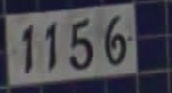

In [22]:
img

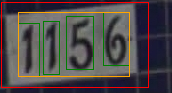

In [23]:
img_boxes

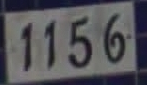

In [24]:
img_cropped

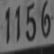

In [25]:
img_trans

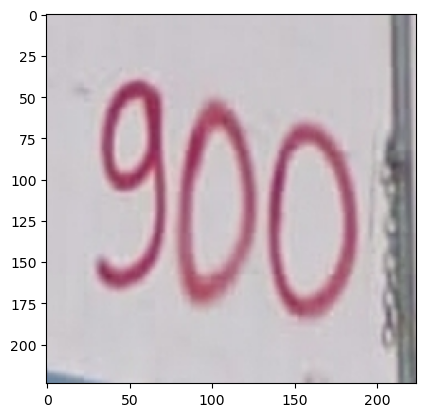

In [6]:
plt.imshow(input_image)

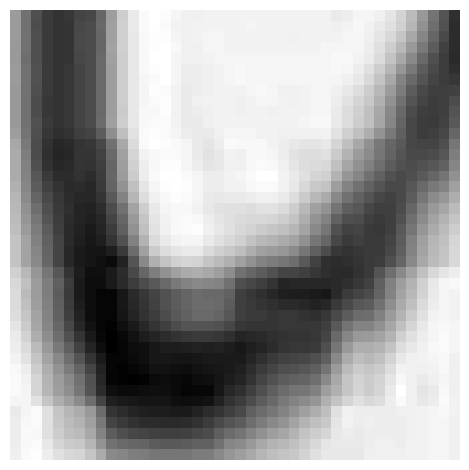

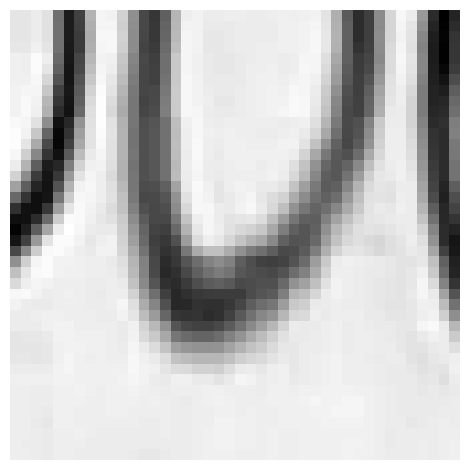

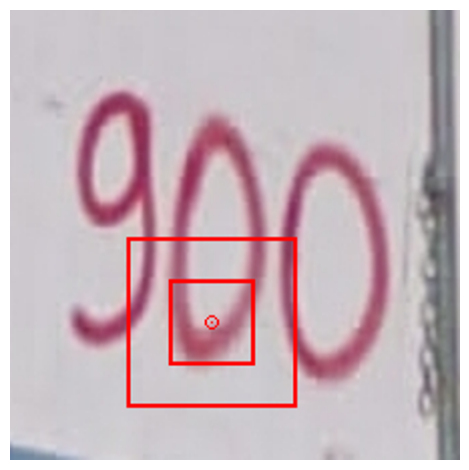

In [56]:
def rgb_to_grayscale(img):
    array = np.array(img)
    gray_array = array.mean(axis=2)
    return Image.fromarray(gray_array.astype("uint8"))

input_image = img_cropped.resize((224, 224))
image_draw = input_image.copy()
draw = ImageDraw.Draw(image_draw)

location = (100, 155)

draw.point(location, fill="red")
radius = 3
draw.ellipse((location[0]-radius, location[1]-radius, location[0]+radius, location[1]+radius), outline="red")

patch_size = int(12*(224/64))
scale = 2
k = 2
size = patch_size

for i in range(k):
    v = int(size/2)
    x1 = location[0] - v
    y1 = location[1] - v
    x2 = location[0] + v
    y2 = location[1] + v
    
    draw.rectangle((x1, y1, x2, y2), outline="red", width=2)
    
    patch = input_image.crop((x1, y1, x2, y2)).resize((patch_size, patch_size))
    fig, ax = plt.subplots()
    ax.imshow(rgb_to_grayscale(patch), cmap="gray")
    ax.axis(False)
    plt.tight_layout()
    plt.show()
    
    size *= scale
    
fig, ax = plt.subplots()
ax.imshow(image_draw.resize((498, 498)))
ax.axis(False)
plt.tight_layout()
plt.show()
    

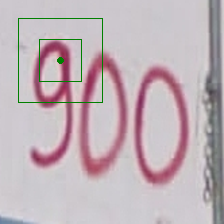

In [24]:
image_draw.

#### Plot on the amount of samples per number of digits that appear in an image

In [8]:
# get number of digits per image in ALL the dataset
num_digits = []
for data in [train_data, val_data, test_data]:
    num_digits += [len(i["boxes"]) for i in data]

/tmp/ipykernel_2846592/3928420966.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([None]+x.tolist())


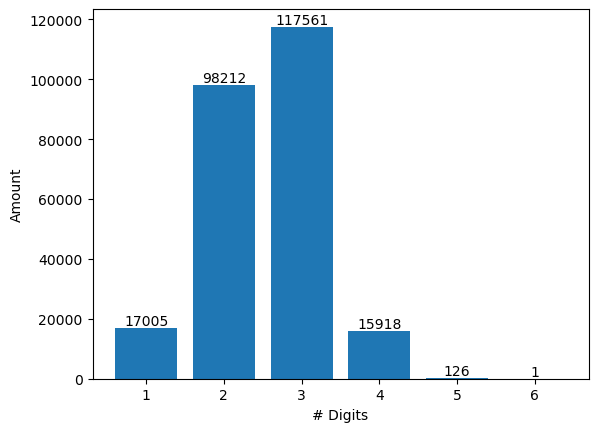

In [9]:
x, y = np.unique(num_digits, return_counts=True)

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.bar(x, y)
ax.set_xlabel('# Digits')
ax.set_ylabel('Amount')
ax.set_xticklabels([None]+x.tolist())

# Make some labels.
labels = [f"{i}" for i in y]
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    );